# Imports and data

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [36]:
data = pd.read_csv('data/st.csv')
data.head()
data.describe()

,Price,Year,Mileage,Distance,Private
count,151.000000,151.000000,151.000000,151.000000,151.000000
mean,8132.033113,2015.622517,64193.708609,174.311258,0.278146
std,1909.756782,1.043978,24036.228957,64.870454,0.449577
min,3030.000000,2014.000000,19000.000000,7.000000,0.000000
25%,6674.000000,2015.000000,46605.000000,136.000000,0.000000
50%,8295.000000,2016.000000,62000.000000,173.000000,0.000000
75%,9499.500000,2016.000000,79000.000000,207.000000,1.000000
max,12999.000000,2017.000000,164530.000000,357.000000,1.000000


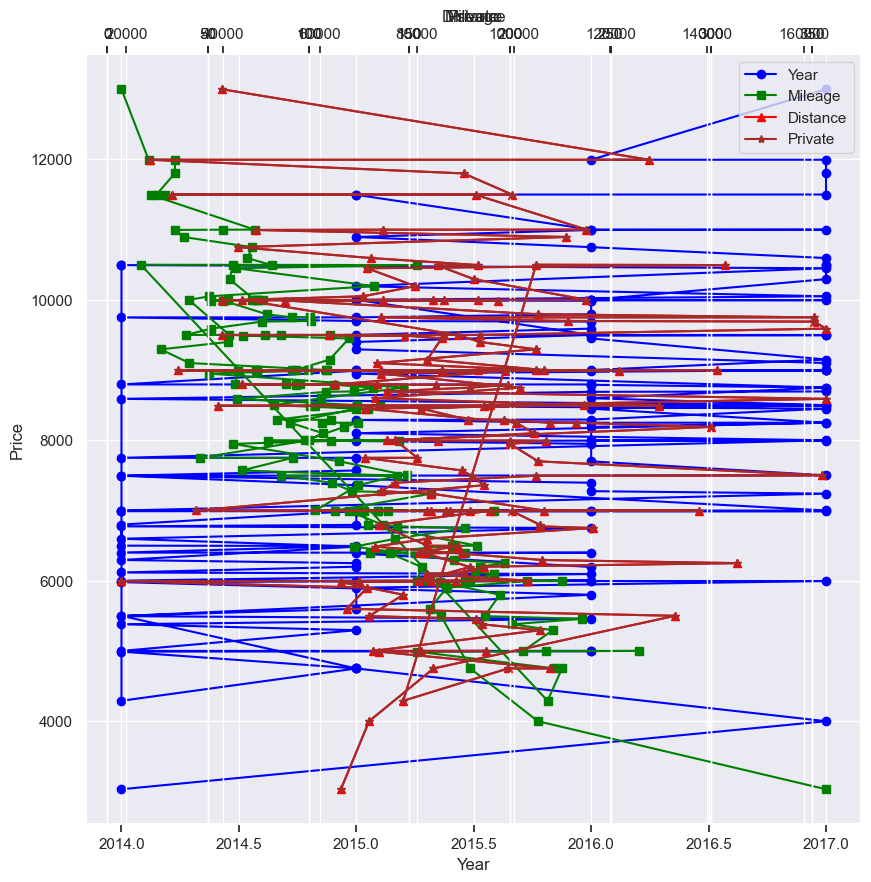

In [14]:
y = data['Price']
x1 = data['Year']
x2 = data['Mileage']
x3 = data['Distance']
x4 = data['Private']

fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.plot(x1, y, 'o-', label='Year', color='blue')
ax1.set_ylabel('Price')
ax1.set_xlabel('Year')

ax2 = ax1.twiny()
ax2.plot(x2, y, 's-', label='Mileage', color='green')
ax2.set_xlabel('Mileage')

ax3 = ax1.twiny()
ax3.plot(x3, y, '^-', label='Distance', color='red')
ax3.set_xlabel('Distance')

ax4 = ax1.twiny()
ax4.plot(x3, y, '*-', label='Private', color='brown')
ax4.set_xlabel('Private')

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.show()

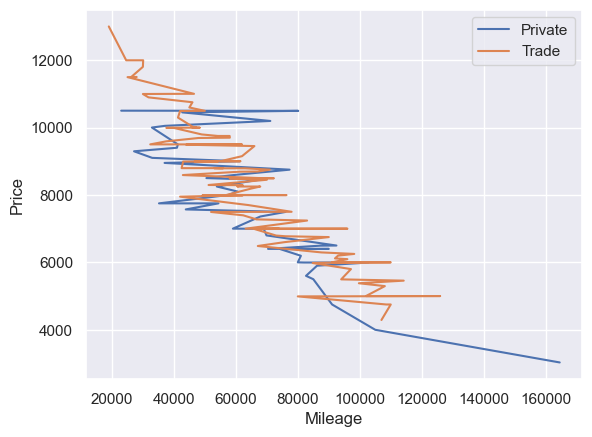

In [15]:
private_data = data[data['Private'] == 1]
trade_data = data[data['Private'] == 0]

y_private = private_data['Price']
y_trade = trade_data['Price']

x2p = private_data['Mileage']
x2t = trade_data['Mileage']

plt.plot(x2p, y_private, label='Private')
plt.plot(x2t, y_trade, label='Trade')

plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend()

plt.show()

# Modelling

In [29]:
X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

mine = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1],
    'Private': [1]
})

In [17]:
variables = data[['Year', 'Mileage', 'Distance', 'Private']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,15.395988,Year
1,8.241456,Mileage
2,8.448038,Distance
3,1.418574,Private


## No split

In [18]:
model_lr = LinearRegression()
model_lr.fit(X,y)
p_lr = model_lr.predict(mine).astype(int)
model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = model_lr.coef_

model_dtr = DecisionTreeRegressor()
model_dtr.fit(X,y)
p_dtr = model_dtr.predict(mine).astype(int)

model_rfr = RandomForestRegressor()
model_rfr.fit(X,y)
p_rfr = model_rfr.predict(mine).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X,y)
p_gbr = model_gbr.predict(mine).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X,y)
p_xgb = model_xgb.predict(mine).astype(int)

print(f'Linear:         {p_lr[0]}')
print(f'Decision Tree:  {p_dtr[0]}')
print(f'Random Forest:  {p_rfr[0]}')
print(f'Gradient Boost: {p_gbr[0]}')
print(f'XGB Boost:      {p_xgb[0]}')
print(f'Mean:           {int(np.mean([p_lr,p_dtr,p_rfr,p_gbr,p_xgb]))}')

model_lr_summary

Linear:         9927
Decision Tree:  10050
Random Forest:  10211
Gradient Boost: 10161
XGB Boost:      10297
Mean:           10129


,Features,Weights
0,Year,329.861206
1,Mileage,-0.065325
2,Distance,0.439928
3,Private,-406.874969


## Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
p_lr = model_lr.predict(X_test).astype(int)

model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train,y_train)
p_dtr = model_dtr.predict(X_test).astype(int)

model_rfr = RandomForestRegressor(random_state=42, criterion='absolute_error')
model_rfr.fit(X_train,y_train)
p_rfr = model_rfr.predict(X_test).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X_train,y_train)
p_gbr = model_gbr.predict(X_test).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train,y_train)
p_xgb = model_xgb.predict(X_test).astype(int)

mae_lr = mean_absolute_error(y_test, p_lr)
mae_dtr = mean_absolute_error(y_test, p_dtr)
mae_rfr = mean_absolute_error(y_test, p_rfr)
mae_gbr = mean_absolute_error(y_test, p_gbr)
mae_xgb = mean_absolute_error(y_test, p_xgb)

print(f'Linear:         {p_lr[:5]}\tMAE: {int(mae_lr)}')
print(f'Random Forest:  {p_rfr[:5]}\tMAE: {int(mae_rfr)}')
print(f'Gradient Boost: {p_gbr[:5]}\tMAE: {int(mae_gbr)}')
print(f'XGB Boost:      {p_xgb[:5]}\tMAE: {int(mae_xgb)}')
print(f'Decision Tree:  {p_dtr[:5]}\tMAE: {int(mae_dtr)}')

int(model_lr.predict(mine)[0])

Linear:         [7377 7404 9837 8389 9556]	MAE: 753
Random Forest:  [5931 7410 9834 8235 9638]	MAE: 837
Gradient Boost: [6005 7302 9935 8189 9888]	MAE: 880
XGB Boost:      [ 5669  7003 10047  8294  9999]	MAE: 963
Decision Tree:  [ 4750  6995  9990  8190 10000]	MAE: 1140


9832

## Tuning and experimenting

In [30]:
model_0 = RandomForestRegressor(random_state=42)
model_1 = RandomForestRegressor(random_state=42, criterion='absolute_error')
model_2 = RandomForestRegressor(random_state=42, min_samples_split=20)
model_3 = RandomForestRegressor(random_state=42, criterion='absolute_error', max_depth=7, min_samples_split=6)
model_4 = RandomForestRegressor(n_estimators=50, random_state=42)
model_5 = RandomForestRegressor(n_estimators=100, random_state=42)
model_6 = RandomForestRegressor(n_estimators=200, random_state=42)
models = [model_0, model_1, model_2, model_3, model_4, model_5, model_6]

def score_model(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

results = []
for i in range(0, len(models)):
    mae = score_model(models[i])
    result = {f'Model {i}':int(mae)}
    results.append(result)
sorted_results = sorted(results, key=lambda x: list(x.values())[0])
for result in sorted_results:
    model, number = list(result.items())[0]
    print(f"{model} MAE: \t{number}")

int(model_1.predict(mine)[0])

Model 1 MAE: 	837
Model 3 MAE: 	838
Model 6 MAE: 	863
Model 0 MAE: 	868
Model 5 MAE: 	868
Model 4 MAE: 	873
Model 2 MAE: 	898


10269

In [42]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Linear Regression CV MAE:", -scores.mean().astype(int))

dt = DecisionTreeRegressor()
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Decision Tree CV MAE:", -scores.mean().astype(int))

# Hyperparameter tuning for Decision Tree
param_grid = {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print("Best params for Decision Tree:", grid_search.best_params_)
print("Best CV MAE for Decision Tree:", -grid_search.best_score_.astype(int))

# Evaluate on test set
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
print("Test MAE for Decision Tree:", mean_absolute_error(y_test, y_pred).astype(int))

rf = RandomForestRegressor()
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Random Forest CV MAE:", -scores.mean().astype(int))

Linear Regression CV MAE: 609
Decision Tree CV MAE: 846
Best params for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
Best CV MAE for Decision Tree: 713
Test MAE for Decision Tree: 929
Random Forest CV MAE: 689


In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse.astype(int)}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae.astype(int)}')

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Mean Squared Error: 941702
Mean Absolute Error: 805


C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
